# Hands on Computer Vision: Build Production-Grade Models in an Hour

This notebook demonstrates practical implementations of core computer vision tasks using pre-trained deep learning models. We'll explore the image classification task.

**Image Classification**: Identifying the main subject or category of an image using state-of-the-art models

The notebook includes:
- Loading and preprocessing images
- Using pre-trained models for inference
- Visualizing and interpreting results

Prerequisites:
- Basic Python knowledge
- Understanding of NumPy and PyTorch
- Familiarity with image processing concepts

All required dependencies are listed in the requirements.txt file of the repository.

# Setup and Imports

Before diving into computer vision tasks, let's set up our environment to access project files and utilities. This step ensures we can easily load images and use helper functions from our project structure.

In [1]:
# all imports
import sys
import torch
import random
import numpy as np
import glob as glob
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from urllib.request import urlopen

In [2]:
# Set up Python path to access our utility modules
# Since this notebook is in the 'notebooks' directory, we need to add the parent (repo root) 
# to the Python path to be able to import from the 'src' directory

# Get current notebook's path and add repo root to Python path
notebook_path = Path().resolve()
repo_root = notebook_path.parent.parent
sys.path.append(str(repo_root))

# Import pre-defined paths to our image directories
# These paths are defined in src/paths.py for consistent use across the project
from src.paths import CLASSIFICATION_IMAGES, DETECTION_IMAGES, SEGMENTATION_IMAGES
# path where to save the downloaded models
from src.paths import MODELS_DIR
# Now we can use these paths to access our images for each task:
# CLASSIFICATION_IMAGES - for image classification
# DETECTION_IMAGES - for object detection
# SEGMENTATION_IMAGES - for semantic segmentation

In [3]:
# Check if CUDA (GPU) is available
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


# Image Classification

Image classification is the task of identifying what's in an image by assigning it a label from a set of predefined categories. For example, determining if a photo contains a dog, cat, car, or person.

When implementing image classification, you have several approaches:
1. Build your own models from scratch - giving you full control but requiring extensive training data and computational resources
2. Use pre-trained models - leveraging models already trained on large datasets like ImageNet 
3. Fine-tune pre-trained models on your specific dataset - combining the best of both worlds

For most real-world applications, using pre-trained models (approach #2) is the smart choice. These models have already learned to recognize a wide variety of visual features, allowing you to:
- Get started quickly without extensive training data
- Save significant time and computing resources
- Often achieve better results than training from scratch

In this tutorial, we'll use a pre-trained model called **Inception V3** to classify images. 

>> If you're interested in fine-tuning Inception V3 on your own dataset, check out the resources section at the bottom of this notebook for a reference repository.

Let's get started! 👇

## Introducing Inception V3

Inception V3 is a convolutional neural network architecture that was developed by Google. It's an evolution of the original GoogLeNet (Inception V1) architecture and has become one of the most widely used models for image classification tasks.

![Inception V3 Architecture](https://production-media.paperswithcode.com/methods/inceptionv3onc--oview_vjAbOfw.png)

<div style="text-align: center;">
    <strong>Image Source</strong>: https://production-media.paperswithcode.com/methods/inceptionv3onc--oview_vjAbOfw.png
</div>

<br>

**Key features of Inception V3:**
- Achieves high accuracy while maintaining computational efficiency
- Uses "inception modules" that perform convolutions at different scales simultaneously  
- Incorporates factorized convolutions to reduce the number of parameters
- Trained on over a million images from the ImageNet database
- Can classify images into 1,000 different categories

The model's efficiency comes from its unique architecture which uses multiple smaller convolutions instead of a few larger ones. This not only reduces the number of parameters but also helps the model learn both local features (through smaller convolutions) and higher-level features (through larger convolutions) simultaneously.

We'll use a pre-trained version of Inception V3, which means the model has already learned to recognize features from millions of images. This approach, known as transfer learning, allows us to leverage the model's powerful feature extraction capabilities without having to train it from scratch.

Let's see how we can use this model to classify our images of different dog breeds!

**Reference**  
[1] Szegedy, C., Vanhoucke, V., Ioffe, S., Shlens, J., & Wojna, Z. (2016). "Rethinking the Inception Architecture for Computer Vision." In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR). [arXiv:1512.00567](https://arxiv.org/abs/1512.00567)

## Example Image Classification Task


In [4]:
# Utility function to load files for any given task
def get_files_path_for_task(task):
    if task == "image_classification":
        dir_path = CLASSIFICATION_IMAGES
    elif task == "object_detection":
        dir_path = DETECTION_IMAGES
    elif task == "semantic_segmentation":
        dir_path = SEGMENTATION_IMAGES
    else:
        raise ValueError(f"Unknown task to load files: {task}")
    files = []
    for ext in ['.jpg', '.jpeg', '.png', '.webp']:
        files.extend(list(dir_path.glob(f'*{ext}')))
    
    # Sort files for consistent ordering
    files.sort()
    
    print("Found image files for task {task}: ")
    for img_path in files:
        print(f"- {img_path.name}")
    return files


In [5]:
# get file paths for image classification task
image_classification_files = get_files_path_for_task(task="image_classification")

Found image files for task {task}: 
- Beagle.jpg
- Bulldog.jpg
- FrenchBullDog.jpg
- GoldenRetriever.png
- cat-pexels-pixabay-266784.jpg


### Visualize an Image

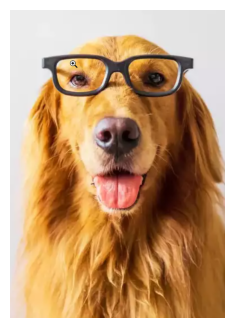

In [6]:
def visualize_image(image_path):
    plt.figure(figsize=(8,4))
    classification_image = plt.imread(image_path)
    plt.imshow(classification_image)
    plt.axis("off")

# We will use the French Bulldog image for prediction. let's load and display it
img_classification_fpath = image_classification_files[3] # French Bulldog is at idx 2
visualize_image(img_classification_fpath)

### ImageNet Classes

The Inception V3 model we'll be using was trained on the ImageNet dataset, which contains 1,000 different classes. These classes include various objects, animals, and scenes. Let's look at a random sample of these classes to get an idea of what the model can recognize:

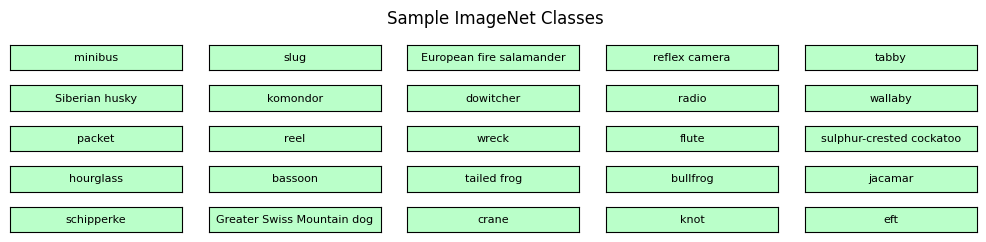

In [7]:
# utility function to plot the labels in a grid
def plot_random_labels(labels_to_plot, title):
   random.seed(42)
   class_names = random.sample(labels_to_plot, 25)
    
   # Light green pastel color
   pastel_color = '#BAFFC9'
   
   fig, ax = plt.subplots(5, 5, figsize=(10, 2.5))
   fig.suptitle(title, fontsize=12, y=0.95)
   
   for i, (name, subplot) in enumerate(zip(class_names, ax.flat)):
       # Create a colored background rectangle
       subplot.add_patch(plt.Rectangle((0, 0), 1, 1, facecolor=pastel_color))
       subplot.text(0.5, 0.5, name, ha='center', va='center', fontsize=8)
       subplot.set_xticks([])
       subplot.set_yticks([])
   
   plt.tight_layout()

# Get ImageNet class labels and display a sample
labels = urlopen("https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt").read().decode().splitlines()
plot_random_labels(labels, title="Sample ImageNet Classes")

### Utility Functions for prediction and visualization

In [8]:
def predict_and_plot_pytorch(image_path, model, preprocess, class_labels, title="Model Predictions"):
    """
    Make predictions using PyTorch models and visualize results
    """
    # Load image
    image = Image.open(image_path)
    
    # Get predictions
    with torch.no_grad():
        input_tensor = preprocess(image).unsqueeze(0).to(device)
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
    
    # Get top 5 predictions
    probs, catids = torch.topk(probabilities, 5, largest=True)
    probs = probs.cpu().numpy()[::-1]
    catids = catids.cpu().numpy()[::-1]
    
    # Create label dictionary
    labels_dict = {i: label for i, label in enumerate(class_labels)}
    
    # Plot results
    plot_predictions(image, probs, catids, labels_dict, title)

def plot_predictions(image, probs, catids, labels_dict, title):
    """
    Helper function to plot the image and predictions
    """
    plt.figure(figsize=(10, 4))
    
    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Input Image")
    plt.axis('off')
    
    # Top 5 predictions
    plt.subplot(1, 2, 2)
    bars = plt.barh(np.arange(5), probs)
    plt.yticks(np.arange(5), [labels_dict[idx] for idx in catids])
    plt.xlabel('Probability')
    plt.title(title)
    
    # Add probability values on bars
    for bar in bars:
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
                f'{bar.get_width():.3f}', 
                va='center', ha='left', fontsize=9)
    
    plt.xlim(0, max(probs) * 1.1)
    plt.tight_layout()

## Loading the Inception V3 Model
Let's load the pre-trained Inception V3 model from torchvision. We'll also set up the necessary transforms to preprocess our images to match the format the model expects.

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /Users/hansimgluck/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [01:04<00:00, 1.69MB/s] 


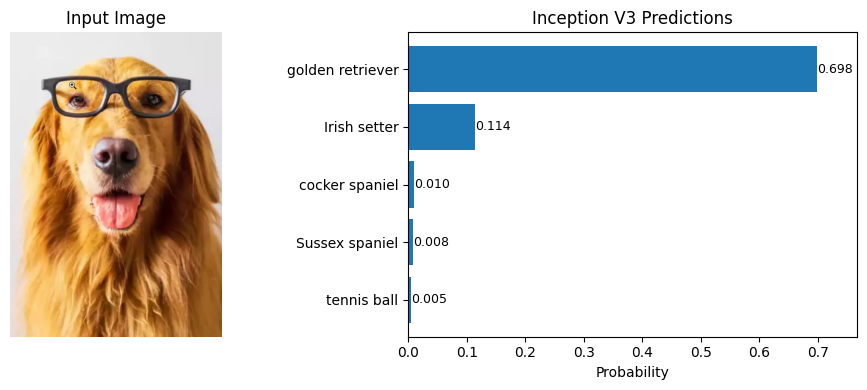

In [9]:
from torchvision.models import inception_v3, Inception_V3_Weights
from torchvision import transforms

# Load Inception V3 model
inception_weights = Inception_V3_Weights.IMAGENET1K_V1
inception_model = inception_v3(weights=inception_weights).to(device)
inception_model.eval()
inception_preprocess = inception_weights.transforms()
img_classification_fpath

# Inception prediction
predict_and_plot_pytorch(img_classification_fpath, inception_model, inception_preprocess, labels, "Inception V3 Predictions")

## Using a Different Pre-trained Model: ResNet-50

One of the advantages of using modern deep learning frameworks like PyTorch is how easy it is to experiment with different pre-trained models. Let's make predictions on the same image using ResNet-50, another powerful CNN architecture.

ResNet-50 is a 50-layer deep convolutional neural network that introduced the concept of "residual connections" or "skip connections". These connections help solve the vanishing gradient problem in deep networks, allowing for much deeper architectures to be trained effectively. Like Inception V3, this model has also been pre-trained on ImageNet and achieves excellent performance on image classification tasks.

Key features of ResNet-50:
- 50 layers deep with residual connections
- Trained on ImageNet's 1000 classes
- Highly influential architecture that won the ILSVRC 2015 competition
- Known for its strong feature extraction capabilities and efficiency

Let's see how ResNet-50's predictions compare with our previous results from Inception V3!

**References**  
[1] He, K., Zhang, X., Ren, S., & Sun, J. (2016). "Deep Residual Learning for Image Recognition." In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR). [arXiv:1512.03385](https://arxiv.org/abs/1512.03385)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/hansimgluck/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:50<00:00, 2.04MB/s]


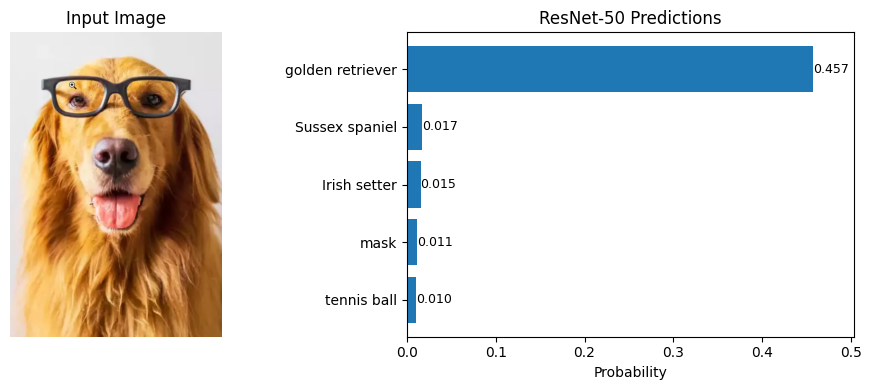

In [10]:
from torchvision.models import resnet50, ResNet50_Weights

# Load ResNet model
resnet_weights = ResNet50_Weights.IMAGENET1K_V2
resnet_model = resnet50(weights=resnet_weights).to(device)
resnet_model.eval()
resnet_preprocess = resnet_weights.transforms()

# ResNet prediction
predict_and_plot_pytorch(img_classification_fpath, resnet_model, resnet_preprocess, labels, "ResNet-50 Predictions")

## Using Specialized Pre-trained Models

While models trained on ImageNet are great general-purpose feature extractors, sometimes we need models trained or fine-tuned for specific tasks. There are several platforms where you can find models trained or fine-tuned for specific domains:

1. Hugging Face Hub (🤗): A platform hosting thousands of models, including many specialized computer vision models
2. PyTorch Hub: Official model repository from PyTorch team
3. TensorFlow Hub: Google's repository of pre-trained models
4. Papers with Code: Website linking papers to implemented models
5. Model Zoo: Collection of pre-trained deep learning models

For our dog breed classification task, we can find models specifically fine-tuned for dog breed identification. Let's try one from the Hugging Face Hub that's been trained to recognize different dog breeds. This model should potentially give us more precise predictions for our specific use case compared to the general-purpose ImageNet models.

/opt/anaconda3/envs/AML_Tut/lib/python3.8/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/anaconda3/envs/AML_Tut/lib/python3.8/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you

Loading specialized dog breed model...


preprocessor_config.json:   0%|          | 0.00/374 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/7.35k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/234M [00:00<?, ?B/s]

Making prediction on image...


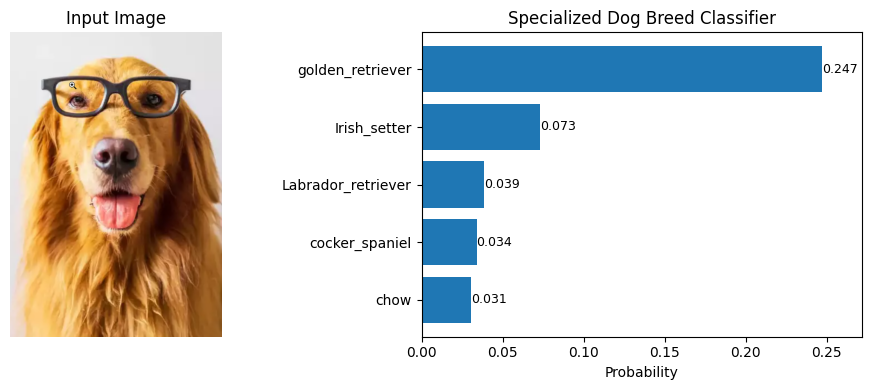

In [14]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

# We will need different preprocessing steps for the HF model
def predict_and_plot_hf(image_path, model, processor, title="Model Predictions"):
    """
    Make predictions using HuggingFace models and visualize results
    """
    # Load image
    image = Image.open(image_path)
    
    # Get predictions
    inputs = processor(image, return_tensors="pt")
    # Move inputs to the same device as model
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = torch.nn.functional.softmax(outputs.logits[0], dim=0)
    
    # Get top 5 predictions
    probs, catids = torch.topk(probabilities, 5, largest=True)
    probs = probs.cpu().numpy()[::-1]
    catids = catids.cpu().numpy()[::-1]
    
    # Plot results
    plot_predictions(image, probs, catids, model.config.id2label, title)

# Load the specialized dog breed classification model
print("Loading specialized dog breed model...")
image_processor = AutoImageProcessor.from_pretrained("jhoppanne/Dogs-Breed-Image-Classification-V2")
dog_model = AutoModelForImageClassification.from_pretrained("jhoppanne/Dogs-Breed-Image-Classification-V2").to(device)
dog_model.eval()

# Make prediction with the specialized model
print("Making prediction on image...")
predict_and_plot_hf(img_classification_fpath, dog_model, image_processor, "Specialized Dog Breed Classifier")

Voila ! You did it!
In conclusion, the versatility of leveraging pre-trained models like InceptionV3 for image classification showcase state-of-the-art performance, enabling efficient and accurate solutions for diverse computer vision tasks with minimal effort.